In [88]:
import csv
from functools import lru_cache
from itertools import groupby
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import periodogram

In [2]:
start_year = 2005
start_month = 4
end_year = 2019
end_month = 12

headers = [
    "UsageClass",
    "CheckoutType",
    "MaterialType",
    "CheckoutYear",
    "CheckoutMonth",
    "Checkouts",
    "Title",
    "Creator",
    "Subjects",
    "Publisher",
    "PublicationYear",
]

header_map = {
    name: idx for idx,name in enumerate(headers)
}

In [3]:
# data/filtered/Unique_Titles.txt is generated by scripts/unique_titles.py
# It contains each unique title that has been checked out during at least 4 months
with open("../data/filtered/Unique_Titles.txt") as inf:
    titles = {x.strip() for x in inf.readlines()}

In [4]:
# data/filtered/Checkouts_by_Title.csv is generated by scripts/select_data.sh
# which in turn uses the xsv command line utility to filter for pysical books
# with open("../data/filtered/Checkouts_by_Title.csv") as inf:
#     iter_csv = pd.read_csv(inf, iterator=True, chunksize=1000)
#     df = pd.concat([chunk[(chunk['Title'].isin(sample_titles))] for chunk in iter_csv])

In [5]:
def convert_date_to_index(start_year, start_month, year, month):
    return (12*(year - start_year)) + (month - start_month)

In [6]:
@lru_cache()
def compute_total_signal_length(start_year, start_month, end_year, end_month):
    return 1 + convert_date_to_index(start_year, start_month, end_year, end_month)

def convert_record_set_to_signal(records, start_year, start_month, end_year, end_month):
    total_length = compute_total_signal_length(start_year, start_month, end_year, end_month)
    signal = [0] * total_length
    for record in records:
        year = int(record[header_map["CheckoutYear"]])
        month = int(record[header_map["CheckoutMonth"]])
        count = int(record[header_map["Checkouts"]])
        idx = convert_date_to_index(start_year, start_month, year, month)
        try:
            signal[idx] = count
        except IndexError:
            print(f"Index {idx} with signal {signal} caused by {year}, {month}, {start_year}, {start_month} and {total_length}")
    return signal

In [7]:
def test_case(case, function):
    params = case[:-1]
    expected_result = case[-1]
    result = function(*params)
    try:
        assert result == expected_result
    except AssertionError:
        print(f"Expected case: {case}, got {result}")
    
def run_test(test):
    function = test["function"]
    cases = test["cases"]
    for case in cases:
        test_case(case, function)


tests = [
    {
        "cases": [
            (2014, 4, 2014, 4, 0),
            (2014, 4, 2014, 5, 1),
            (2014, 4, 2015, 1, 9)
        ],
        "function": convert_date_to_index
    },
    {
        "cases": [
            (2014, 4, 2014, 4, 1),
            (2014, 4, 2015, 4, 13),
        ],
        "function": compute_total_signal_length
    }
]

for test in tests:
    run_test(test)    

In [37]:
def read_partitions(directory, limit=1):
    counter = 0
    results = {}
    for root, dirs, files in os.walk(directory):
        for file in files:
            if counter >= limit:
                break
            with open(os.path.join(directory, file)) as inf:
                reader = csv.reader(inf)
                records = sorted(list(reader), key=lambda x: x[6])
                results.update({
                    title: convert_record_set_to_signal(record_set, start_year, start_month, end_year, end_month) for title,record_set in groupby(records, key=lambda x: x[6])
                })
                counter += 1
    return results
                

In [77]:
results = read_partitions("../data/partitioned", limit=100)

In [78]:
sample_titles = titles.intersection(results.keys())

In [79]:
candidate_signals = {k:v for k,v in results.items() if k in sample_titles}

In [159]:
top_christmas_stories = sorted([(x, sum(candidate_signals[x])) for x in sample_titles if 'christmas' in x.lower()], key=lambda x: -1*x[1])[:10]
other_stories = sorted([(x, sum(candidate_signals[x])) for x in sample_titles if 'dogs' in x.lower()], key=lambda x: -1*x[1])[:10]
sample_stories = [*top_christmas_stories, *other_stories ]

In [160]:
# target_title = 'Elmer\'s Christmas / David McKee.'
# target_title = 'How the Grinch stole Christmas, by Dr. Seuss.'
# signal = candidate_signals[target_title]
# f, Pxx_den = periodogram(signal, len(signal))

def generate_periodogram(title, signal):
    return periodogram(signal, len(signal))

signals = {
    top[0]: generate_periodogram(top[0], candidate_signals[top[0]]) for top in sample_stories
}

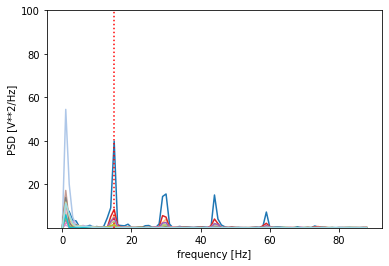

In [161]:
colormap = mpl.cm.tab20.colors
plt.ylim([1e-3, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
for i,dat in enumerate(signals.items()):
    title, (f, Pxx_den) = dat
    # Uncomment to view a single title
#     if title != "How the Grinch stole Christmas, by Dr. Seuss.":
#         continue
#     print(candidate_signals[title])
    color = colormap[i]
#     plt.semilogy(f, Pxx_den, color=color, nonposy="clip")
    plt.plot(f, Pxx_den, color=color)
# EXPECT every 12 months, offset 3 months from the starting month (April, the fourth month)
plt.axvline(x=12+4-1, color='r', linestyle=":")
plt.show()

In [162]:
# We expect a yearly periodicity around christmas
# Can we do something better here? Some titles have a spike when they're released, or a short cycle
# around two months that looks like it corresponds to to the "overdue book returned and checked out" syndrome
def is_periodic_around_christmas(signal):
    return (max([ (i,v) for i,v in enumerate(signal)], key=lambda pair: pair[1])[0] - 3) % 12 == 0

def is_periodic_around_christmas2(signal):
    abs_avg = np.average(np.abs(signal))
    abs_std = np.std(np.abs(signal))
    return signal[15] > abs_avg + (3*abs_std)

print("Is the title periodic around the Christmas season?")
for i,dat in enumerate(signals.items()):
    title, (f, Pxx_den) = dat
#     print(f"{'yes' if is_periodic_around_christmas(Pxx_den) else 'non'} - {title}")
    print(f"{'yes' if is_periodic_around_christmas2(Pxx_den) else 'non'} - {title}")

Is the title periodic around the Christmas season?
yes - How the Grinch stole Christmas, by Dr. Seuss.
non - Barbie : a perfect Christmas / adapted by Christy Webster ; illustrations by Das Grüp Incorporated.
non - Harold at the North Pole; a Christmas journey with the purple crayon.
yes - It's Christmas, David! / by David Shannon.
non - A royal Christmas / written by Lisa Ann Marsoli ; illustrated by the Disney Storybook Artists.
yes - The Berenstain Bears' old-fashioned Christmas / Jan & Mike Berenstain.
yes - The twelve days of Christmas in Washington / written and illustrated by John Abbott Nez.
yes - Little Bunny and the magic Christmas tree / David Martin ; illustrated by Valeri Gorbachev.
yes - Elmer's Christmas / David McKee.
yes - How the Easter Bunny saved Christmas / written and illustrated by Derek Anderson.
non - Circle dogs / by Kevin Henkes ; illustrated by Dan Yaccarino.
non - Shaggy dogs, waggy dogs / by Patricia Hubbell ; illustrated by Donald Wu.
non - I got two dogs